## Importing Packages and Modules

In [1]:
import os
import shutil
import zipfile

import cv2
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, udf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import ArrayType, FloatType

import tensorflow as tf


## Downloading Dataset from Kaggle

In [2]:
# Create the .kaggle directory if it doesn't exist
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the kaggle.json file
shutil.move("kaggle.json", "/root/.kaggle/")

# Set permissions
os.chmod("/root/.kaggle/kaggle.json", 600)

In [3]:
# Download kaggle dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:22<00:00, 89.9MB/s]
100% 2.29G/2.29G [00:22<00:00, 109MB/s] 


In [4]:
# Unzip the dataset
with zipfile.ZipFile("/content/chest-xray-pneumonia.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

print("Dataset extracted successfully!")

Dataset extracted successfully!


## Splitting Train, Test, Validation Dataset

In [5]:
# Directories for train,val, test data
train_dir = "/content/dataset/chest_xray/train/"
val_dir = "/content/dataset/chest_xray/val/"
test_dir = "/content/dataset/chest_xray/test/"

In [6]:
def extract_img_paths(split_path):
    """
    extract imgs path from train, test, val directories
    """

    imgs = []
    name_to_label = {"NORMAL":0,
                "PNEUMONIA":1}

    for folder in os.listdir(split_path):
        for img_path in os.listdir(os.path.join(split_path, folder)):
            if img_path.endswith(".jpeg"):
                imgs.append((os.path.join(split_path, folder, img_path), name_to_label[folder]))

    return imgs

In [7]:
# Store all image paths and their labels to list of tuples
train_imgs = extract_img_paths(train_dir)
val_imgs = extract_img_paths(val_dir)
test_imgs = extract_img_paths(test_dir)

In [ ]:
print(train_imgs[0:3])
print(test_imgs[0:3])
print(val_imgs[0:3])

[('/content/dataset/chest_xray/train/NORMAL/IM-0476-0001.jpeg', 0), ('/content/dataset/chest_xray/train/NORMAL/NORMAL2-IM-0914-0001.jpeg', 0), ('/content/dataset/chest_xray/train/NORMAL/NORMAL2-IM-0838-0001.jpeg', 0)]
[('/content/dataset/chest_xray/test/NORMAL/NORMAL2-IM-0332-0001.jpeg', 0), ('/content/dataset/chest_xray/test/NORMAL/IM-0039-0001.jpeg', 0), ('/content/dataset/chest_xray/test/NORMAL/NORMAL2-IM-0173-0001-0001.jpeg', 0)]
[('/content/dataset/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg', 0), ('/content/dataset/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg', 0), ('/content/dataset/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg', 0)]


## Start Spark Session

In [8]:
# Start a spark session
spark = SparkSession.builder.appName("Chest X-Ray Classification").master('local[*]').config("spark.driver.memory", "15g").getOrCreate()

## Convert Image Paths to Dataframe

In [9]:
def imgs_path_to_df(imgs):
  """
  Convert list of tuples to dataframe with two columns, image_path and label
  """

  schema = StructType([StructField("image_path", StringType(), True),
                       StructField("label", IntegerType(), True)])

  df = spark.createDataFrame(imgs, schema=schema)

  return df


In [10]:
# Store all image paths and labels to dataframe
train_df = imgs_path_to_df(train_imgs)
val_df = imgs_path_to_df(val_imgs)
test_df = imgs_path_to_df(test_imgs)

In [ ]:
train_df.take(4)

[Row(image_path='/content/dataset/chest_xray/train/NORMAL/IM-0476-0001.jpeg', label=0),
 Row(image_path='/content/dataset/chest_xray/train/NORMAL/NORMAL2-IM-0914-0001.jpeg', label=0),
 Row(image_path='/content/dataset/chest_xray/train/NORMAL/NORMAL2-IM-0838-0001.jpeg', label=0),
 Row(image_path='/content/dataset/chest_xray/train/NORMAL/IM-0240-0001.jpeg', label=0)]

In [ ]:
# Count of each class
train_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 3875|
|    0| 1341|
+-----+-----+



In [ ]:
val_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|    8|
|    0|    8|
+-----+-----+



In [ ]:
test_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  390|
|    0|  234|
+-----+-----+



## Visualizing Random Images

In [11]:
def plot_imgs(df, num_images_to_plot=10):
  """
  Plots some random images from df, num_images_to_plot determines the number of images to be plot
  """
  label_to_name = {0:"NORMAL",
                   1:"PNEUMONIA"}

  rdd = df.rdd
  random_rows = rdd.takeSample(False, num_images_to_plot)

  plt.figure(figsize=(10, 6))
  plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    top=0.3, # padding to the top in order to have a clear subplots
                    right=0.9,
                    wspace=0.4,
                    hspace=0.4)

  i = 0
  for img_path, label in random_rows:
    img = plt.imread(img_path)
    img = cv2.resize(img, (224, 224))
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.imshow(img, cmap=plt.cm.bone)
    plt.title(label_to_name[label], fontsize=9)
    plt.axis("off")
    i += 1

  plt.show()

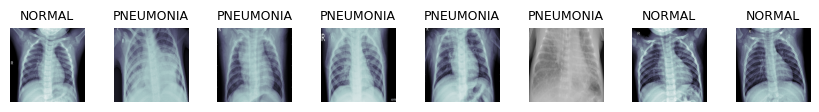

In [ ]:
# Plot some images from train dataset
plot_imgs(train_df, 8)

## Pixel Extraction from Images

In [16]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

def pixel_extraction(path):
  """
  Get all pixels of images and return them as a list
  """

  img = tf.keras.preprocessing.image.load_img(path, target_size = (224, 224)) # resize image size to (224, 224)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  # img = tf.keras.applications.resnet50.preprocess_input(img)
  img = img / 255.0   # normalize pixels
  img = preprocess_input(img)

  model = VGG16(weights='imagenet', include_top=False)
  features = model.predict(img)

  return features.flatten().tolist()


In [17]:
# wrapper user-defined function
pixels = udf(pixel_extraction, ArrayType(FloatType()))

## Add column features to each dataframe

In [18]:
# Add column 'features' to each dataframe that contains pixels of images
train_df = train_df.withColumn("features", pixels(train_df.image_path))
val_df = val_df.withColumn("features", pixels(val_df.image_path))
test_df = test_df.withColumn("features", pixels(test_df.image_path))

In [19]:
train_df.show(3)

+--------------------+-----+--------------------+
|          image_path|label|            features|
+--------------------+-----+--------------------+
|/content/dataset/...|    0|[0.0, 0.0, 0.0, 0...|
|/content/dataset/...|    0|[0.0, 0.0, 0.0, 0...|
|/content/dataset/...|    0|[0.0, 0.0, 0.0, 0...|
+--------------------+-----+--------------------+
only showing top 3 rows



## Drop column image_path from each dataframe

In [20]:
# drop and remove column 'image_path' from each dataframe
train_df = train_df.drop("image_path")
val_df = val_df.drop("image_path")
test_df = test_df.drop("image_path")

In [21]:
train_df.show(3)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.0, 0.0, 0.0, 0...|
|    0|[0.0, 0.0, 0.0, 0...|
|    0|[0.0, 0.0, 0.0, 0...|
+-----+--------------------+
only showing top 3 rows



## Convert column features to vector

In [22]:
from pyspark.ml.linalg import Vectors, VectorUDT

def array_to_vector(feature):
  """
  Cast column features to vector

  """
  return Vectors.dense(feature)


In [23]:
array_to_vector = udf(array_to_vector, VectorUDT())

In [24]:
# Convert column 'features' into Vector format
train_df = train_df.withColumn("features", array_to_vector("features"))
val_df = val_df.withColumn("features", array_to_vector("features"))
test_df = test_df.withColumn("features", array_to_vector("features"))

In [25]:
train_df.show(3)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.0,0.0,0.0,0.0,...|
|    0|[0.0,0.0,0.0,0.0,...|
|    0|[0.0,0.0,0.0,0.0,...|
+-----+--------------------+
only showing top 3 rows



## Assemble column features to column features_vector

In [26]:
from pyspark.ml.feature import VectorAssembler

vector_assembler = VectorAssembler(inputCols=["features"], outputCol="features_vector")

# Assemble column 'features' into 'features_vector'
train_df = vector_assembler.transform(train_df).select("features_vector", "label")
val_df = vector_assembler.transform(val_df).select("features_vector", "label")
test_df = vector_assembler.transform(test_df).select("features_vector", "label")

In [27]:
train_df.show(5)

+--------------------+-----+
|     features_vector|label|
+--------------------+-----+
|(25088,[44,113,15...|    0|
|(25088,[44,113,15...|    0|
|(25088,[44,113,13...|    0|
|(25088,[44,113,13...|    0|
|(25088,[44,113,13...|    0|
+--------------------+-----+
only showing top 5 rows



## Models

In [ ]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [28]:
# Create an object to evalute each model performance
evaluator = MulticlassClassificationEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "accuracy")

## Logistic Regression

In [29]:
# Create a Logistic Regression Model
lr = LogisticRegression(featuresCol = "features_vector", labelCol = "label")

# Train the model
lr_model = lr.fit(train_df)

# Predict on val_df
lr_predictions = lr_model.transform(val_df)

# Accuracy for val_df
lr_acc = evaluator.evaluate(lr_predictions)

print(f"Validation Accuracy - Logistic Regression: {lr_acc * 100:.2f}%")


Validation Accuracy - Logistic Regression: 100.00%


In [31]:
# evaluate on test_df
predictions = lr_model.transform(test_df)

# accuracy for test_df
accuracy = evaluator.evaluate(predictions)

print(f"The accuracy of the logistic regression model for test_df is: {accuracy}")

The accuracy of the logistic regression model for test_df is: 0.7564102564102564


## Random Forest

In [ ]:
rf = RandomForestClassifier(featuresCol="features_vector", labelCol="label")

# train model
rf_model = rf.fit(train_df)

# Predict on val_df
rf_predictions = rf_model.transform(val_df)

# Accuracy for val_df
rf_acc = evaluator.evaluate(rf_predictions)

print(f"Validation Accuracy - Random Forest: {rf_acc * 100:.2f}%")

In [ ]:
# evaluate on test_df
predictions = rf_model.transform(test_df)

# accuracy for test_df
accuracy = evaluator.evaluate(predictions)

print(f"The accuracy of the Random Forest model for test_df is: {accuracy}")